# Import des Librairies utiles au projet

In [158]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from numpy.random import RandomState
import scipy.stats
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder

# A partir des différents datasets à notre disposition sur les courses de Formule 1, comment peut-on prédire quelle écurie gagnera la course ?

### Le dataset que nous avons utilisé est disponible à l'adresse suivante : https://www.kaggle.com/datasets/melissamonfared/formula-1/data
Les données que nous possédons proviennet de multiples jeux de données aux facteurs variés. Chacun d'entre eux contient des informations qu peuvent nous être utiles pour prédire le résultat de la course.

Notre jeu de données contient les csv suivants :
 1. Circuits
 2. Constructor results
 3. Constructor standings
 4. Constructors
 5. drivers
 6. driver standings
 7. Lap times
 8. Pit stops
 9. Qualifying
 10. Races
 11. Results
 12. Seasons
 13. Sprint results
 14. Status

Avant de passer à l'entraînement de notre model, il nous faut déjà visualiser une première fois nos données, pour identifier les variables qui ont le plus d'impacts, si certaines colonnes sont vides, si certaines données sont inutilisables, etc... Cette étape nous aidera à faire les démarches nécessaires au nettoyage de notre dataset afin qu'il soit le plus performant possible.

In [159]:
# Lecture rapide des csv

circuits_df = pd.read_csv('circuits.csv')
print("Circuits :\n", circuits_df.head())

constructor_results_df = pd.read_csv('constructor_results.csv')
print("Constructor_results :\n",constructor_results_df.head())

constructor_standings_df = pd.read_csv('constructor_standings.csv')
print("Constructor_standings :\n",constructor_standings_df.head())

constructors_df = pd.read_csv('constructors.csv')
print("Constructors :\n",constructors_df.head())

driver_standings_df = pd.read_csv('driver_standings.csv')
print("Driver_standings :\n",driver_standings_df.head())

drivers_df = pd.read_csv('drivers.csv')
print("Drivers :\n",drivers_df.head())

lap_times_df = pd.read_csv('lap_times.csv')
print("Lap_times :\n",lap_times_df.head())

pit_stops_df = pd.read_csv('pit_stops.csv')
print("Pit_stops :\n",pit_stops_df.head())

qualifying_df = pd.read_csv('qualifying.csv')
print("Qualifying :\n",qualifying_df.head())

races_df = pd.read_csv('races.csv')
print("Races :\n",races_df.head())

results_df = pd.read_csv('results.csv')
print("Results :\n",results_df.head())

seasons_df = pd.read_csv('seasons.csv')
print("Seasons :\n",seasons_df.head())

sprint_results_df = pd.read_csv('sprint_results.csv')
print("Sprint_results :\n",sprint_results_df.head())

status_df = pd.read_csv('status.csv')
print("Status :\n",status_df.head())

Circuits :
    circuitId   circuitRef                            name      location  \
0          1  albert_park  Albert Park Grand Prix Circuit     Melbourne   
1          2       sepang    Sepang International Circuit  Kuala Lumpur   
2          3      bahrain   Bahrain International Circuit        Sakhir   
3          4    catalunya  Circuit de Barcelona-Catalunya      Montmeló   
4          5     istanbul                   Istanbul Park      Istanbul   

     country       lat        lng  alt  \
0  Australia -37.84970  144.96800   10   
1   Malaysia   2.76083  101.73800   18   
2    Bahrain  26.03250   50.51060    7   
3      Spain  41.57000    2.26111  109   
4     Turkey  40.95170   29.40500  130   

                                                 url  
0  http://en.wikipedia.org/wiki/Melbourne_Grand_P...  
1  http://en.wikipedia.org/wiki/Sepang_Internatio...  
2  http://en.wikipedia.org/wiki/Bahrain_Internati...  
3  http://en.wikipedia.org/wiki/Circuit_de_Barcel...  
4        

# Audit de la qualité des données (Missing Values)

Ici nous regardons quelles sont les proportions de valeurs nulles et aux caractères spéciaux ('\\N') afin de s'en charger à l'avenir dans le preprocessing.

In [160]:
def audit_data_quality(dataframes_dict):
    """Vérifie les valeurs manquantes et les caractères spéciaux comme '\\N'."""
    print("--- Rapport de Qualité des Données ---")
    for name, df in dataframes_dict.items():
        print(f"\nJeu de données : {name.upper()}")
        print(f"Dimensions : {df.shape}")
        
        # Vérifier les NaN standards
        na_count = df.isna().sum().sum()
        
        # Vérifier les '\N' spécifiques à ce dataset Kaggle
        n_str_count = (df == '\\N').sum().sum()
        
        if na_count > 0 or n_str_count > 0:
            print(f"Valeurs NaN : {na_count}")
            print(f"Valeurs '\\N' : {n_str_count}")
            # Afficher les colonnes concernées
            cols_missing = df.columns[(df == '\\N').any() | df.isna().any()].tolist()
            print(f"Colonnes à nettoyer : {cols_missing}")
        else:
            print("Aucune valeur manquante détectée.")

audit_data_quality({
    'circuits': circuits_df,
    'constructor_results': constructor_results_df,
    'constructor_standings': constructor_standings_df,
    'constructors': constructors_df,
    'driver_standings': driver_standings_df,
    'drivers': drivers_df,
    'lap_times': lap_times_df,
    'pit_stops': pit_stops_df,
    'qualifying': qualifying_df,
    'races': races_df,
    'results': results_df,
    'seasons': seasons_df,
    'sprint_results': sprint_results_df,
    'status': status_df
})

--- Rapport de Qualité des Données ---

Jeu de données : CIRCUITS
Dimensions : (77, 9)
Aucune valeur manquante détectée.

Jeu de données : CONSTRUCTOR_RESULTS
Dimensions : (12495, 5)
Valeurs NaN : 0
Valeurs '\N' : 12478
Colonnes à nettoyer : ['status']

Jeu de données : CONSTRUCTOR_STANDINGS
Dimensions : (13261, 7)
Aucune valeur manquante détectée.

Jeu de données : CONSTRUCTORS
Dimensions : (212, 5)
Aucune valeur manquante détectée.

Jeu de données : DRIVER_STANDINGS
Dimensions : (34574, 7)
Aucune valeur manquante détectée.

Jeu de données : DRIVERS
Dimensions : (859, 9)
Valeurs NaN : 0
Valeurs '\N' : 1559
Colonnes à nettoyer : ['number', 'code']

Jeu de données : LAP_TIMES
Dimensions : (575029, 6)
Aucune valeur manquante détectée.

Jeu de données : PIT_STOPS
Dimensions : (10945, 7)
Aucune valeur manquante détectée.

Jeu de données : QUALIFYING
Dimensions : (10234, 9)
Valeurs NaN : 40
Valeurs '\N' : 11424
Colonnes à nettoyer : ['q1', 'q2', 'q3']

Jeu de données : RACES
Dimensions : (1

Après cette première analyse rapide, nous nous appercevons que certains datasets contiennent de nombreuses colonnes aux données manquantes, certaines l'étant presque complètement (comme status avec 12478 nulls pour 12495 lignes). Il nous faudra donc traiter ces cas plus en profondeur en supprimant les lignes concernées par exemple ou en utilisant des techniques de Feature Engineering.

Nous allons commencer notre analyse de données en procédant à quelques analyses univariées et visualisations nous permettant de regarder un peu plus en profondeur nos données et d'en tirer de premières conclusions quand à leurs utilités sur notre modèle. Cela nous permettra également de procéder à une première étape de nettoyage.

### Extraction des datasets

Dans le script suivant nous automatisons  le chargement des 14 fichiers CSV en convertissant le symbole spécifique \N en données nulles (NaN). Cette étape est indispensable pour que la librairie Pandas reconnaisse nos données comme des nombres et non du texte. 
Ensuite nous extrayons ces données de notre dictionnaire vers des variables distinctes (comme results ou drivers) pour simplifier leur utilisation immédiate.

In [161]:
dataframes = {}
file_names = [
    "circuits.csv", "constructor_results.csv", "constructor_standings.csv",
    "constructors.csv", "driver_standings.csv", "drivers.csv",
    "lap_times.csv", "pit_stops.csv", "races.csv", "results.csv", "status.csv", 
    "qualifying.csv", "seasons.csv", "sprint_results.csv"
]
na_val = '\\N'

for f_name in file_names:
    try:
        key = f_name.split('.')[0]
        dataframes[key] = pd.read_csv(f_name, na_values=[na_val])
        print(f"Fichier '{f_name}' chargé.")
    except FileNotFoundError:
        # En cas de mauvaise écriture du csv ou non présence des fichiers dans le bon dossier
        print(f"ERREUR INATTENDUE : Fichier non trouvé : '{f_name}'")
        sys.exit()

#Extraire les datasets
results = dataframes.get('results')
races = dataframes.get('races')
circuits = dataframes.get('circuits')
drivers = dataframes.get('drivers')
constructors = dataframes.get('constructors')
driver_standings = dataframes.get('driver_standings')
constructor_standings = dataframes.get('constructor_standings')
constructor_results = dataframes.get('constructor_results')
status = dataframes.get('status')
lap_times = dataframes.get('lap_times')
pit_stops = dataframes.get('pit_stops')
status = dataframes.get('status')
qualifying = dataframes.get('qualifying')
seasons = dataframes.get('seasons')
sprint_results = dataframes.get('sprint_results')

Fichier 'circuits.csv' chargé.
Fichier 'constructor_results.csv' chargé.
Fichier 'constructor_standings.csv' chargé.
Fichier 'constructors.csv' chargé.
Fichier 'driver_standings.csv' chargé.
Fichier 'drivers.csv' chargé.
Fichier 'lap_times.csv' chargé.
Fichier 'pit_stops.csv' chargé.
Fichier 'races.csv' chargé.
Fichier 'results.csv' chargé.
Fichier 'status.csv' chargé.
Fichier 'qualifying.csv' chargé.
Fichier 'seasons.csv' chargé.
Fichier 'sprint_results.csv' chargé.


# Analyse Univariée et premiers nettoyages

Configuration du style pour les diagrammes, graphes et autres schémas utilisées pour la visualisation.

In [162]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 8)

### Analyse des colonnes urls, lat, lng, alt, location et country de circuits

Dans ce dataset on remarque plusieurs colonnes qui ont l'air de ne pas apporter beaucoup d'informations pertinentes, ou contribuent même à de la redondance et à du bruit. Afin d'évaluer cela nous avons procédé à plusieurs visualisations de ces features pour en déduire, ou non, une certaine pertinence.

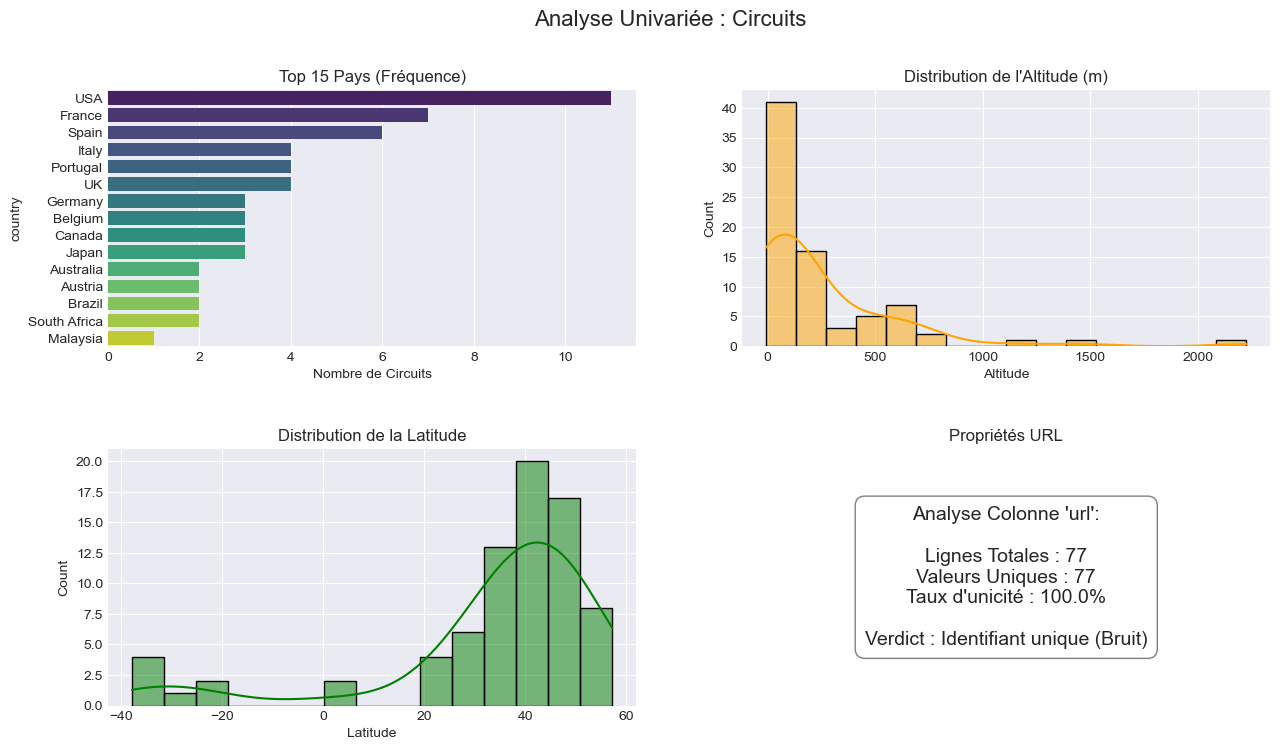

--- Statistiques Descriptives (Altitudes et Latitudes) ---
               alt        lat
count    77.000000  77.000000
mean    247.012987  33.442925
std     362.738469  22.808866
min      -7.000000 -37.849700
25%      18.000000  32.777400
50%     129.000000  40.951700
75%     332.000000  46.958900
max    2227.000000  57.265300


In [163]:
# Création des sous-graphiques
fig, axes = plt.subplots(2, 2)
plt.subplots_adjust(hspace=0.4)

# 1. Country (Top 15 pour lisibilité)
country_counts = circuits['country'].value_counts().head(15)
sns.barplot(x=country_counts.values, y=country_counts.index, hue=country_counts.index, legend=False, ax=axes[0, 0], palette='viridis')
axes[0, 0].set_title('Top 15 Pays (Fréquence)')
axes[0, 0].set_xlabel('Nombre de Circuits')

# 2. Altitude (Distribution Physique)
sns.histplot(circuits['alt'].dropna(), kde=True, ax=axes[0, 1], color='orange')
axes[0, 1].set_title('Distribution de l\'Altitude (m)')
axes[0, 1].set_xlabel('Altitude')

# 3. Latitude (Distribution Géographique)
sns.histplot(circuits['lat'], kde=True, ax=axes[1, 0], color='green')
axes[1, 0].set_title('Distribution de la Latitude')
axes[1, 0].set_xlabel('Latitude')

# 4. URL (Analyse de Cardinalité)
unique_urls = circuits['url'].nunique()
total_rows = len(circuits)
url_info = (f"Analyse Colonne 'url':\n\n"
            f"Lignes Totales : {total_rows}\n"
            f"Valeurs Uniques : {unique_urls}\n"
            f"Taux d'unicité : {(unique_urls/total_rows)*100:.1f}%\n\n"
            f"Verdict : Identifiant unique (Bruit)")

axes[1, 1].text(0.5, 0.5, url_info, ha='center', va='center', fontsize=14, 
                bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="black", alpha=0.5))
axes[1, 1].axis('off')
axes[1, 1].set_title('Propriétés URL')

plt.suptitle('Analyse Univariée : Circuits', fontsize=16)
plt.show()

# Affichage des statistiques numériques
print("--- Statistiques Descriptives (Altitudes et Latitudes) ---")
print(circuits[['alt', 'lat']].describe())

#### Les graphiques et statistiques ci-dessus sont plutôt parlants :

Concernant les pays (en haut à gauche), on peut visualiser aisément que les Etats-Unis, la France ainsi que l'Espagne dominent en nombre de circuits historiques.
Cette colonne peut être intéressante à garder puisqu'il pourrait être intéressant s'il est possible de visualiser dans les victoires des pilotes locaux un "effet domicile". Nous décidons donc de garder cette variable pour le moment.

Cependant, la variable "location" indiquant la ville dans laquelle se trouve le circuit n'apporte rien de plus. Sans avoir besoin de vérifier la disparité nous avons donc décidé de la retirer.

In [164]:
circuits.drop(columns=['location'], inplace=True, errors='ignore')

Pour ce qui est de l'altitude (en haut à droite), on remarque sur le graphique un  point extrême à plus de 2200m. Cela correspond au circuit de Mexico. La plupart des courses se trouvant au niveau de la mer (0-200m), on en déduit que les quelques courses en altitude (Autriche, Brésil, et surtout Mexique) créent des conditions physiques radicalement différentes à cause de la raréfication de l'air.
Ainsi, les performances des écuries ne seront vraisemblablement pas les mêmes car les configurations techniques des véhicules sont plus ou moins adaptées aux fortes et basses altitudes. Cette caractéristique est donc à conserver.

Pour les latitudes (en bas à gauche), on observe une distribution très concentrée entre 30° et 50° Nord. Cela correspond à l'Europe et aux Etats-Unis ce qui valide notre réflexion précédente sur l'étude univariée des pays. L'utilité de cette variable est plutôt faible puisqu'elle ne sert qu'à indiquer que la F1 est un sport euro-centré. Cela n'explique en rien les performances du constructeur et est plutôt redondant puisque nous connaissons déjà les pays dans lesquels se trouvent les circuits.

Il en va de même pour les longitudes.

Nous pouvons donc les supprimer.



In [165]:
circuits.drop(columns=['lat'], inplace=True, errors='ignore')
circuits.drop(columns=['lng'], inplace=True, errors='ignore')

Enfin, concernant les urls (en bas à droite), ce sont des identifiants uniques (puisque l'on observe un taux de 100% d'unicité) qui ne sont là que de manière informative. Pour notre modèle statistique ce n'est que du bruit pur. Ainsi il nous faut retirer cette colonne.

Sans analyse supplémentaire nécessaire, nous nous doutons que la pertinence de cette variable est la même dans chacun des jeux de données. Ainsi, nous éliminons cette colonne dans chacun des csvs qui la contient.

In [166]:
races.drop(columns=['url'], inplace=True, errors='ignore')
drivers.drop(columns=['url'], inplace=True, errors='ignore')
constructors.drop(columns=['url'], inplace=True, errors='ignore')
circuits.drop(columns=['url'], inplace=True, errors='ignore')
seasons.drop(columns=['url'], inplace=True, errors='ignore')

Une dernière colonne nécessitant un nettoyage est circuitRef puisque ce n'est qu'une version redondante de circuitId également illisible par notre modèle et donc inutile. 

In [167]:
circuits.drop(columns=['circuitRef'], inplace=True, errors='ignore')

Nouveau dataset nettoyé :

In [168]:
print("Circuits :\n", circuits.head())

Circuits :
    circuitId                            name    country  alt
0          1  Albert Park Grand Prix Circuit  Australia   10
1          2    Sepang International Circuit   Malaysia   18
2          3   Bahrain International Circuit    Bahrain    7
3          4  Circuit de Barcelona-Catalunya      Spain  109
4          5                   Istanbul Park     Turkey  130


### Analyse des lignes vides de la colonne status de constructors_results

Dans notre première analyse sur la qualité de nos datasets, nous avions remarqué que la colonne status de notre fichier constructors_results.csv contennait une majorité de valeures nulles. Nous allons visualiser cette répartition et tenter d'en déduire une conclusion quand à leur utilité pour notre modèle.

Distribution de la colonne 'status' :
status
NaN    12478
D         17
Name: count, dtype: int64

Pourcentage :
status
NaN    99.86%
D       0.14%
Name: proportion, dtype: object


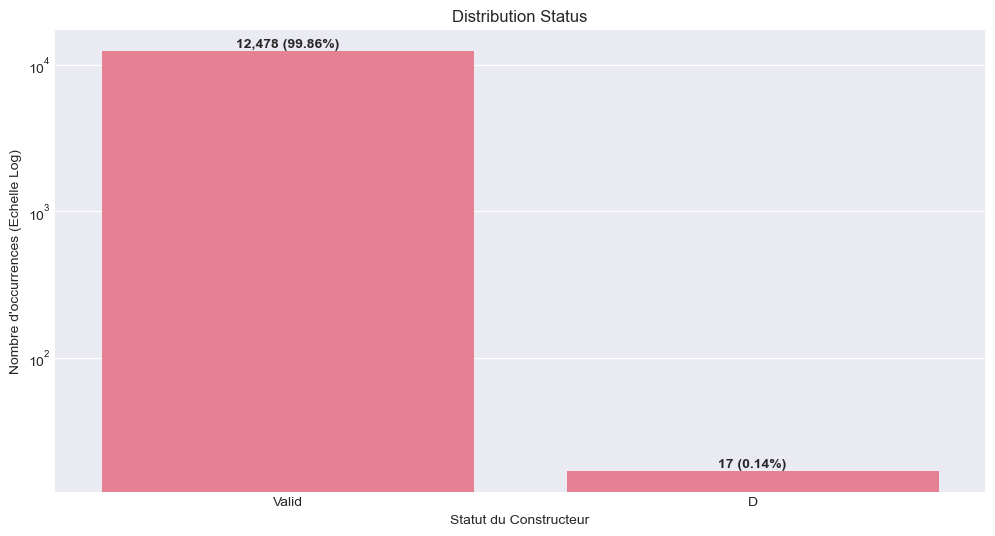

In [169]:
# Inspection des chiffres bruts
print("Distribution de la colonne 'status' :")
print(constructor_results['status'].value_counts(dropna=False))
print("\nPourcentage :")
print(constructor_results['status'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str) + '%')

# Visualisation
plt.figure(figsize=(12, 6))

# Remplissage temporaire des NaN pour visualisation, permet de voir la catégorie "Valid" explicitement sur le graphe
sns.countplot(
    x=constructor_results['status'].fillna('Valid'),
    order=['Valid', 'D'] # On force l'ordre pour la lisibilité
)

plt.title("Distribution Status")
plt.yscale('log') # Echelle log pour visualiser les valeurs minoritaires
plt.ylabel("Nombre d'occurrences (Echelle Log)")
plt.xlabel("Statut du Constructeur")

# Ajout annotations
plt.text(0, 12478, '12,478 (99.86%)', ha='center', va='bottom', fontweight='bold')
plt.text(1, 17, '17 (0.14%)', ha='center', va='bottom', fontweight='bold')

plt.show()

Après cette première étude, nous observons comme attendu un fort déséquilbre entre les nuls (appelés Valid) et les constructeurs contenant un statut "D". 

Ce déséquilibre pourrait être intéressant si nous cherchions à déterminer les écuries championnes d'une saison de F1, seulement ici nous nous concentrons uniquement sur une course. Ainsi, il nous est inutile de savoir quelle voiture a été disqualifiée pour triche (comme McLaren en 2007 avec le scandale Spygate) puisque cela ne révèle en rien ses performances techniques sur le terrain.

Ainsi, nous pouvons donc supprimer cette colonne de notre dataset.

In [170]:
constructor_results.drop(columns=['status'], inplace=True, errors='ignore')

Nouveau dataset nettoyé :

In [171]:
print("Constructor_results :\n",constructor_results.head())

Constructor_results :
    constructorResultsId  raceId  constructorId  points
0                     1      18              1    14.0
1                     2      18              2     8.0
2                     3      18              3     9.0
3                     4      18              4     5.0
4                     5      18              5     2.0


### Nettoyage de constructor_standings 

Pour ce dataset, nous avons décidé de supprimer la colonne positionText. En effet, celle-ci n'est qu'une duplication au format texte de la variable numérique position et n'apporte aucune information supplémentaire exploitable. Sa suppression élimine une redondance inutile et prévient l'introduction de bruit (valeurs non numériques) qui pourrait perturber l'apprentissage de notre modèle.

In [172]:
constructor_standings.drop(columns=['positionText'], inplace=True, errors='ignore')

Nouveau dataset nettoyé :

In [173]:
print("Constructor_standings :\n",constructor_standings.head())

Constructor_standings :
    constructorStandingsId  raceId  constructorId  points  position  wins
0                       1      18              1    14.0         1     1
1                       2      18              2     8.0         3     0
2                       3      18              3     9.0         2     0
3                       4      18              4     5.0         4     0
4                       5      18              5     2.0         5     0


### Nettoyage Driver_standings :

Même cas que pour Constructor standings avec la colonne positionText.

In [174]:
driver_standings.drop(columns=['positionText'], inplace=True, errors='ignore')

Nouveau dataset nettoyé :

In [175]:
print("Driver_standings :\n",driver_standings.head())

Driver_standings :
    driverStandingsId  raceId  driverId  points  position  wins
0                  1      18         1    10.0         1     1
1                  2      18         2     8.0         2     0
2                  3      18         3     6.0         3     0
3                  4      18         4     5.0         4     0
4                  5      18         5     4.0         5     0


### Analyse de la distribution des nationalités des constructeurs

Cette analyse univariée a pour but d'identifier de potentiels biais géographiques historiques dans l'ingénierie automobile pour voir si l'origine d'une écurie influence sa probabilité de succès.

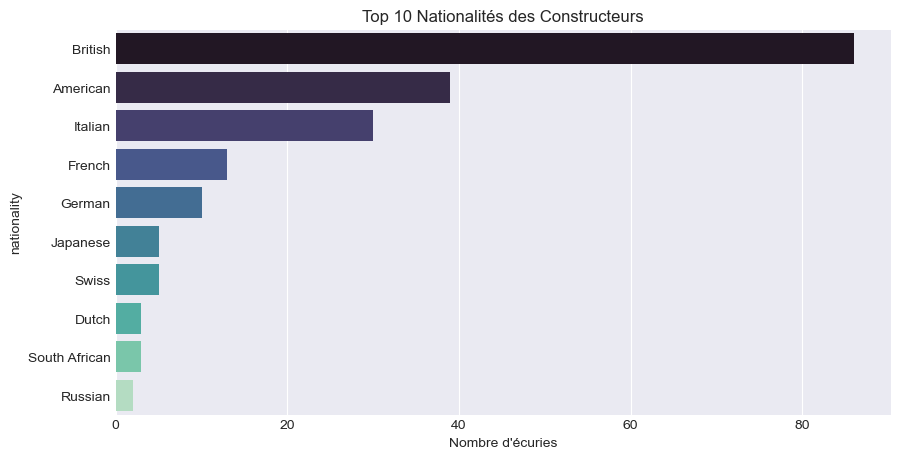

In [176]:
plt.figure(figsize=(10, 5))
nat_counts = constructors['nationality'].value_counts().head(10)

sns.barplot(
    x=nat_counts.values, 
    y=nat_counts.index, 
    hue=nat_counts.index, 
    legend=False, 
    palette='mako'
)

plt.title("Top 10 Nationalités des Constructeurs")
plt.xlabel("Nombre d'écuries")
plt.show()

Après visualisation des résultats, le graphique révèle une hégémonie du Royaume-Uni, loin devant l'Italie et les Etats-Unis. La variable nationality est donc discriminante, mais sa haute cardinalité exigera peut-être de regrouper les "petites nations" pour éviter le bruit.

### Analyse de la distribution des nationalités des pilotes

Dans l'analyse du dataset circuit, nous avions dit qu'il serait intéressant d'analyser la corrélation possibles des victoires à domicile afin d'en conclure d'un potentiel avantage à mettre en avant pour notre modèle. L'analyse de la distribution des nationalités des pilotes pourrait également révèler de potentiels biais historiques (domination de certains pays).

Contrairement à la nationalité des constructeurs qui traduit une domination technologique et industrielle, celle des pilotes met en lumière les viviers de talents historiques. Cette distinction est cruciale pour identifier les biais structurels du dataset, notamment la sur-représentation de nations comme le Royaume-Uni ou l'Allemagne. De plus, isoler cette variable est indispensable pour le feature engineering futur, afin de tester l'hypothèse du "Home Advantage" en croisant la nationalité du pilote avec celle du circuit.

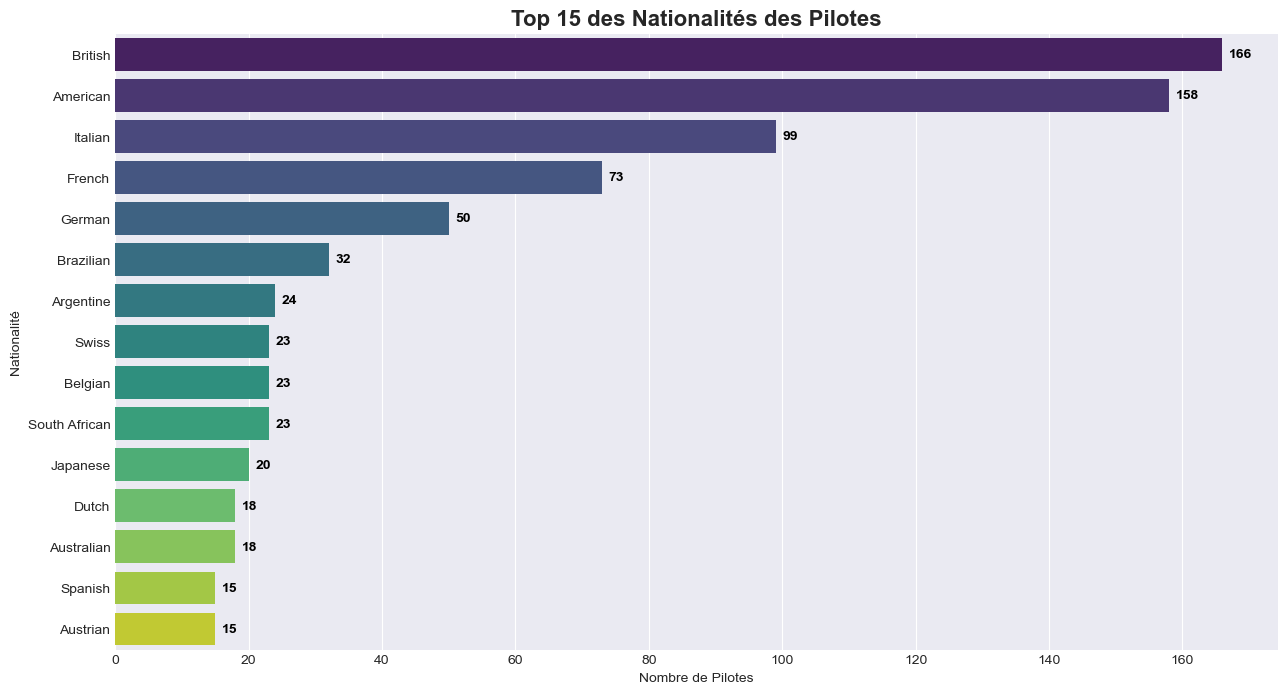

In [177]:
# Calcul des fréquences sur la colonne brute
nationality_counts = drivers['nationality'].value_counts()
top_nationalities = nationality_counts.head(15) # Top 15 pour la lisibilité

# Visualisation
plt.figure(figsize=(15, 8))

sns.barplot(
    x=top_nationalities.values,
    y=top_nationalities.index,
    hue=top_nationalities.index,
    legend=False,
    palette='viridis'
)

plt.title('Top 15 des Nationalités des Pilotes', fontsize=16, fontweight='bold')
plt.xlabel('Nombre de Pilotes')
plt.ylabel('Nationalité')

# Ajout des valeurs au bout des barres
for i, v in enumerate(top_nationalities.values):
    plt.text(v + 1, i, str(v), color='black', va='center', fontweight='bold')

plt.show()

Avec ce graphique, on déduit une certaine hégémonie de quelques nations historiques (comme le Royaume-Uni, les États-Unis ou encore l'Italie) face à une longue liste de pays jugés anecdotiques.

Ce fort déséquilibre signifie que la variable nationality contient beaucoup de bruit (haute cardinalité avec peu de fréquence) et devra probablement être simplifiée (par exemple en regroupant les "petites" nations) pour être utile à notre modèle prédictif.

### Nettoyage du fichier drivers

Pour ce dataset, nous avons identifié plusieurs colonnes qui n'ont pas vraiment d'utilité dans la prédiction de la victoire ou non d'une écurie sur un circuit.

##### Distribution en pourcentage de la colonne nombre

In [178]:
print(drivers['number'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str) + '%')

number
NaN     93.36%
6.0      0.23%
88.0     0.23%
10.0     0.23%
40.0     0.23%
22.0     0.23%
99.0     0.23%
28.0     0.23%
9.0      0.23%
21.0     0.23%
2.0      0.23%
4.0      0.23%
19.0     0.12%
14.0     0.12%
7.0      0.12%
13.0     0.12%
27.0     0.12%
5.0      0.12%
8.0      0.12%
44.0     0.12%
25.0     0.12%
3.0      0.12%
77.0     0.12%
20.0     0.12%
17.0     0.12%
45.0     0.12%
26.0     0.12%
33.0     0.12%
12.0     0.12%
55.0     0.12%
11.0     0.12%
98.0     0.12%
53.0     0.12%
30.0     0.12%
94.0     0.12%
31.0     0.12%
18.0     0.12%
16.0     0.12%
35.0     0.12%
63.0     0.12%
23.0     0.12%
51.0     0.12%
89.0     0.12%
47.0     0.12%
24.0     0.12%
81.0     0.12%
38.0     0.12%
Name: proportion, dtype: object


La colonne nombre contient 802 valeurs nulles sur 859 (93.36% de vide). Il nous faut donc, si nous la conservons, penser à la nettoyer.
Historiquement, les numéros des pilotes de F1 changeaient chaque année ou n'existaient pas. Aujourd'hui, ils ne sont là que pour le marketing (le numéro 44 est par exemple celui d'Hamilton). Il n'existe donc aucune corrélation physique entre le numéro du pilote et sa vitesse et cela apporte même une redondance si on l'utilise pour son identification. Nous pouvons donc la supprimer.

In [179]:
drivers.drop(columns=['number'], inplace=True, errors='ignore')

#### Distribution en pourcentage de la colonne code

In [180]:
print(drivers['code'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str) + '%')

code
NaN    88.13%
MSC     0.23%
VER     0.23%
MAG     0.23%
HAR     0.23%
        ...  
DEV     0.12%
PIA     0.12%
SAR     0.12%
LAW     0.12%
BEA     0.12%
Name: proportion, Length: 97, dtype: object


La colonne code, comme pour la colonne nombre contient une majorité de valeurs nulles (88.13%).
Cette variable est elle aussi plutôt inutile puisqu'elle n'est que l'abréviation du nom de famille du pilote. Nous pouvons donc la supprimer.

In [181]:
drivers.drop(columns=['code'], inplace=True, errors='ignore')

#### Suppression de driverRef

Cette colonne est une simple répétition des noms de famille, cela est inutile pour notre modèle qui utilisera les driverId pour identifier ces derniers. Nous pouvons donc l'éliminer.

In [182]:
drivers.drop(columns=['driverRef'], inplace=True, errors='ignore')

Nouveau dataset nettoyé :

In [183]:
print("Drivers :\n",drivers.head())

Drivers :
    driverId  forename     surname         dob nationality
0         1     Lewis    Hamilton  1985-01-07     British
1         2      Nick    Heidfeld  1977-05-10      German
2         3      Nico     Rosberg  1985-06-27      German
3         4  Fernando      Alonso  1981-07-29     Spanish
4         5    Heikki  Kovalainen  1981-10-19     Finnish


### Nettoyage de Lap_Times

Pour ce dataset, la seule colonne à retirer est celle appelée time. Celle-ci contient le temps mis par le pilote pour faire un tour de piste. Cependant elle est redondante puisqu'elle est déjà contenue dans la colonnes milliseconds. De plus, le type des données étant un string cela est illisible pour notre modèle.

In [184]:
lap_times.drop(columns=['time'], inplace=True, errors='ignore')

Nouveau dataset nettoyé :

In [185]:
print("Lap_times :\n",lap_times.head())

Lap_times :
    raceId  driverId  lap  position  milliseconds
0     841        20    1         1         98109
1     841        20    2         1         93006
2     841        20    3         1         92713
3     841        20    4         1         92803
4     841        20    5         1         92342


### Analyse distribution des pit_stops et nettoyage du dataframe

L'analyse de la distribution des arrêts aux stands est importante dans notre cas puisqu'elle nous permet d'établir la norme de performance. Elle est utile pour pouvoir définir mathématiquement ce qu'est un arrêt "standard" (le temps incompressible dans la voie des stands + changement de pneus) par rapport à un arrêt "raté" (problème d'écrou, changement d'aileron, pénalité). Cette distinction est cruciale pour le feature engineering, car elle permet de créer un indicateur de fiabilité opérationnelle des écuries en pénalisant les écarts à cette norme, plutôt que d'utiliser une simple moyenne qui serait faussée par les événements rares.

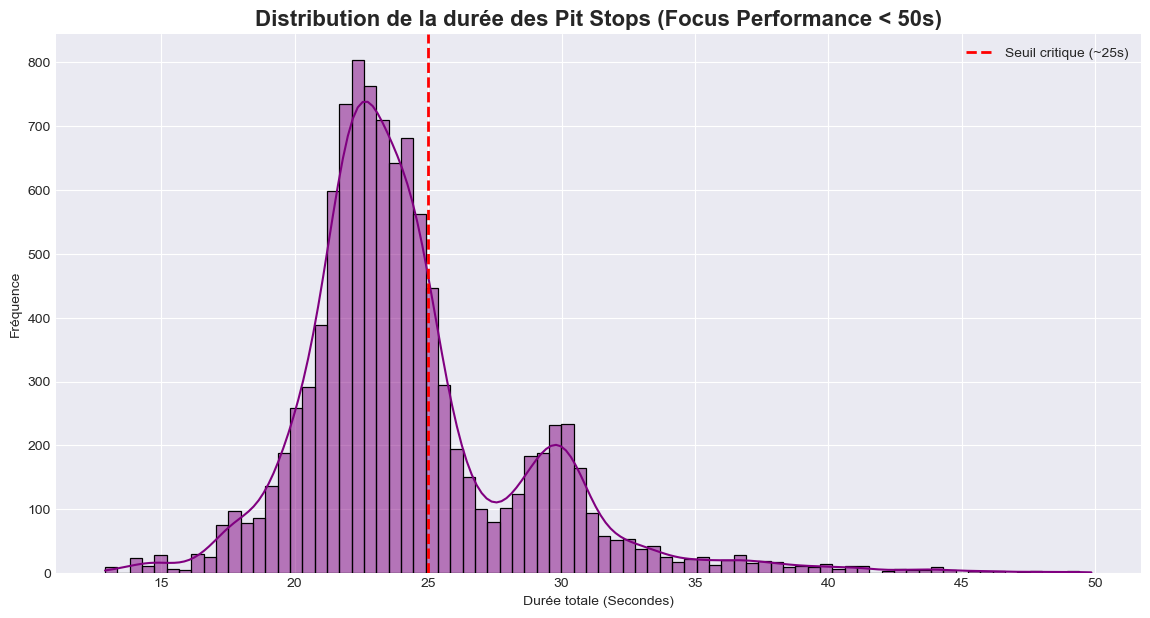

--- Statistiques des Pit Stops (en secondes) ---
count    10945.000000
mean        85.532631
std        312.108764
min         12.897000
25%         21.941000
50%         23.601000
75%         26.399000
max       3069.017000
Name: seconds, dtype: float64

Nombre d'arrêts 'Hors Norme' (>50s) exclus du graphe : 533


In [186]:
# Feature Engineering (Temporaire pour la visualisation)
# Conversion en secondes pour une meilleure analyse et lisibilité
pit_stops['seconds'] = pit_stops['milliseconds'] / 1000

# Visualisation : Distribution des temps d'arrêt
plt.figure(figsize=(14, 7))

# FILTRE STRATÉGIQUE : On ne regarde que les arrêts < 50 secondes.
# Pourquoi ? Parce que les arrêts de 3 minutes (réparations, pluie) écrasent l'échelle et nous empêchent de juger la performance standard des mécaniciens.
subset_pits = pit_stops[pit_stops['seconds'] < 50]

sns.histplot(subset_pits['seconds'], bins=80, kde=True, color='purple')

plt.title('Distribution de la durée des Pit Stops (Focus Performance < 50s)', fontsize=16, fontweight='bold')
plt.xlabel('Durée totale (Secondes)')
plt.ylabel('Fréquence')

# Ajout d'un seuil critique visuel (ex: 25s = arrêt lent/raté)
plt.axvline(x=25, color='red', linestyle='--', linewidth=2, label='Seuil critique (~25s)')
plt.legend()

plt.show()

# Statistiques pour confirmer
print("--- Statistiques des Pit Stops (en secondes) ---")
print(pit_stops['seconds'].describe())
print(f"\nNombre d'arrêts 'Hors Norme' (>50s) exclus du graphe : {len(pit_stops[pit_stops['seconds'] >= 50])}")

L'histogramme met en évidence une distribution gaussienne très nette centrée autour de 23-24 secondes, définissant ainsi la norme de performance opérationnelle pour un arrêt réussi. La chute brutale des fréquences au-delà de 28 secondes permet de tracer une frontière claire entre une simple lenteur et un incident technique ou stratégique majeur. Contrairement à la médiane stable, la moyenne est fortement biaisée par une "longue traîne" d'arrêts anormaux supérieurs à 50 secondes, correspondant à des réparations ou des pénalités. Cette distinction impose de traiter ces valeurs extrêmes comme des anomalies (outliers) dans le modèle, plutôt que de les laisser fausser l'évaluation de l'efficacité des équipes. En somme, la régularité sous le seuil critique des 26 secondes est le véritable indicateur de compétence, tandis que tout dépassement signale une rupture de la normalité.

Pour le nettoyage, ici on retire time et duration pour les mêmes raisons que pour le jeu de données lap_times précèdemment optimisé.

In [187]:
pit_stops.drop(columns=['time'], inplace=True, errors='ignore')
pit_stops.drop(columns=['duration'], inplace=True, errors='ignore')

Nouveau dataset nettoyé :

In [188]:
print("Pit_stops :\n",pit_stops.head())

Pit_stops :
    raceId  driverId  stop  lap  milliseconds  seconds
0     841       153     1    1         26898   26.898
1     841        30     1    1         25021   25.021
2     841        17     1   11         23426   23.426
3     841         4     1   12         23251   23.251
4     841        13     1   13         23842   23.842


### Nettoyage de Qualifying

Drop : qualifyId (Index inutile), number (Redondant avec drivers), q1, q2, q3.

Pourquoi ? Les temps Q1-Q3 sont au format texte ("1:24.333"). Sans feature engineering immédiat (conversion en ms), c'est inexploitable. La colonne position résume déjà toute la séance.

In [189]:
print("Qualifying :\n",qualifying.head())

Qualifying :
    qualifyId  raceId  driverId  constructorId  number  position        q1  \
0          1      18         1              1      22         1  1:26.572   
1          2      18         9              2       4         2  1:26.103   
2          3      18         5              1      23         3  1:25.664   
3          4      18        13              6       2         4  1:25.994   
4          5      18         2              2       3         5  1:25.960   

         q2        q3  
0  1:25.187  1:26.714  
1  1:25.315  1:26.869  
2  1:25.452  1:27.079  
3  1:25.691  1:27.178  
4  1:25.518  1:27.236  


L'Id unique qualifyId du dataset est parfaitement inutile dans notre étude puisque il ne nous apporte aucune information et n'est la clé secondaire d'aucun autre dataset. Ainsi on peut donc supprimer cette feature.

In [190]:
qualifying.drop(columns=['qualifyId'], inplace=True, errors='ignore')

Tout comme pour drivers, la feature number ne sert à rien, surtout que le driverId est déjà renseigné. Cette colonne représente donc une information redondante qui pourrait perdre notre modèle. Nous avons donc décidé de supprimer également cette colonne.

In [191]:
qualifying.drop(columns=['number'], inplace=True, errors='ignore')

Enfin, les temps de qualifications recensés dans q1, q2 et q3 sont actuellement inutilisables pour notre modèle puisque ce sont des temps renseignés sous la forme de string. De plus, ce qui nous intéresse est le pilote (ou constructeur) ayant fait un temps minimal au total sur les 3 tours. Cette information étant déjà transmise par la colonne position, on peut donc supprimer ces données inutiles.

In [192]:
qualifying.drop(columns=['q1'], inplace=True, errors='ignore')
qualifying.drop(columns=['q2'], inplace=True, errors='ignore')
qualifying.drop(columns=['q3'], inplace=True, errors='ignore')

Nouveau dataset nettoyé :

In [193]:
print("Qualifying :\n",qualifying.head())

Qualifying :
    raceId  driverId  constructorId  position
0      18         1              1         1
1      18         9              2         2
2      18         5              1         3
3      18        13              6         4
4      18         2              2         5


### Analyse du nombre de courses par saison et nettoyage du dataset races

Notre but, dans cette étude est de comprendre la distribution temporelle des données pour savoir si le modèle sera entraîné majoritairement sur de la F1 moderne ou ancienne.

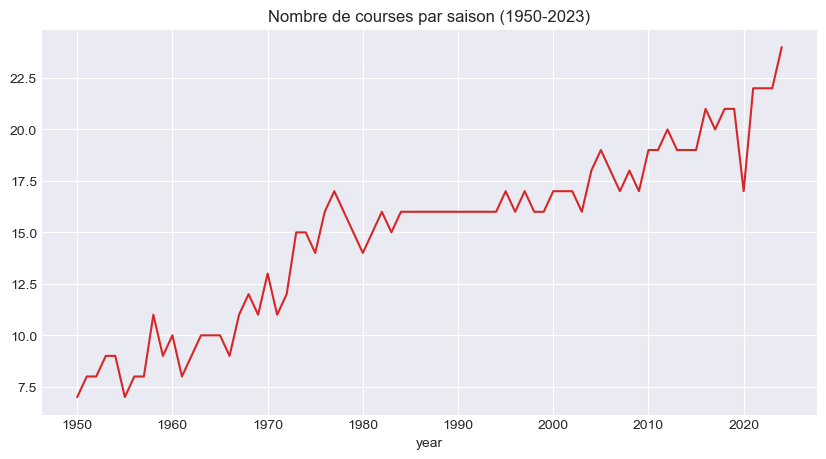

In [194]:
plt.figure(figsize=(10, 5))
races_year = races['year'].value_counts().sort_index()
sns.lineplot(x=races_year.index, y=races_year.values, color='tab:red')
plt.title("Nombre de courses par saison (1950-2023)")
plt.show()

On observe une densification nette du calendrier (passage de 7 à 24 courses). Cette augmentation crée un biais de récence favorable, ainse le modèle aura plus d'exemples sur la F1 moderne, ce qui est idéal pour nous qui souhaitons prédire les courses actuelles.

Pour le nettoyage, on peut supprimer les features fp1_date, fp2_date, fp3_date, quali_date, sprint_date. Celles-ci, en plus d'être vides, représentent les dates des séances d'essais libreset n'ont aucun pouvoir prédictif sur le résultat final.

In [195]:
races.drop(columns=['fp1_date'], inplace=True, errors='ignore')
races.drop(columns=['fp2_date'], inplace=True, errors='ignore')
races.drop(columns=['fp3_date'], inplace=True, errors='ignore')
races.drop(columns=['quali_date'], inplace=True, errors='ignore')
races.drop(columns=['sprint_date'], inplace=True, errors='ignore')

On peut également supprimer les colonnes fp1_time, fp2_time, fp3_time, quali_time, sprint_time. Celles-ci sont également vides pour la plupart et n'indiquent qu'un horaire. Inutile donc dans notre cas. On peut également retirer la variable time qui ne sert qu'à indiquer l'heure de départ.

In [196]:
races.drop(columns=['fp1_time'], inplace=True, errors='ignore')
races.drop(columns=['fp2_time'], inplace=True, errors='ignore')
races.drop(columns=['fp3_time'], inplace=True, errors='ignore')
races.drop(columns=['quali_time'], inplace=True, errors='ignore')
races.drop(columns=['sprint_time'], inplace=True, errors='ignore')
races.drop(columns=['time'], inplace=True, errors='ignore')

Nouveau dataset nettoyé

In [197]:
print("Races :\n",races.head())

Races :
    raceId  year  round  circuitId                   name        date
0       1  2009      1          1  Australian Grand Prix  2009-03-29
1       2  2009      2          2   Malaysian Grand Prix  2009-04-05
2       3  2009      3         17     Chinese Grand Prix  2009-04-19
3       4  2009      4          3     Bahrain Grand Prix  2009-04-26
4       5  2009      5          4     Spanish Grand Prix  2009-05-10


### Analyse de distribution des positions de départ des pilotes victorieux

C'est évidemment le paramètre que l'on attend être le plus important. En effet, il paraît plutôt logique qu'une voiture partant en première position soit plus susceptible de remporter la course.

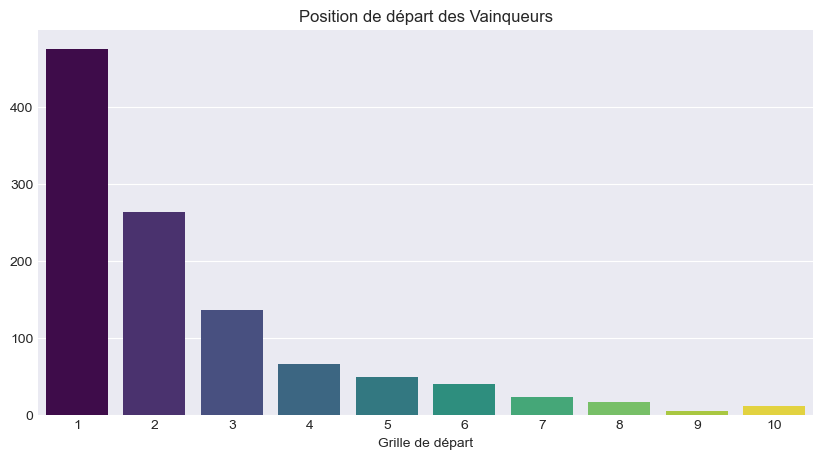

In [198]:
plt.figure(figsize=(10, 5))
winners = results[results['positionOrder'] == 1]
win_grid = winners['grid'].value_counts().sort_index().head(10)

sns.barplot(
    x=win_grid.index, 
    y=win_grid.values, 
    hue=win_grid.index,  
    legend=False,        
    palette='viridis'
)

plt.title("Position de départ des Vainqueurs")
plt.xlabel("Grille de départ")
plt.show()

La corrélation est en effet brutale : la majorité des vainqueurs partent de la Pole Position et les chances de gagner s'effondrent après la 3ème place. Cela confirme que la variable grid sera le prédicteur le plus puissant de notre modèle.

Après cette rapide analyse sur la corrélation possible entre position de départ et vainqueurs, place au nettoyage. Comme pour races et drivers, on peut supprimer la colonne number puirsqu'elle n'apporte rien.

In [199]:
results.drop(columns=['number'], inplace=True, errors='ignore')

PositionText est elle aussi inutile puisque ce n'est qu'une copie de positionOrder au format string, inutilisable pour notre modèle donc.

In [200]:
results.drop(columns=['positionText'], inplace=True, errors='ignore')

Ici, il nous est impératif de supprimer certaines colonnes puisqu'elles comportent un haut risque de Data Leakage. En effet, les colonnes comme fastestLap, rank, milliseconds, ou encore position comportent toutes des données provenant du futur que l'on ne connaît qu'après la course. Les inclure reviendrait donc à donner la réponse au modèle avant qu'il ne fasse sa prédiction.

In [201]:
results.drop(columns=['fastestLap'], inplace=True, errors='ignore')
results.drop(columns=['rank'], inplace=True, errors='ignore')
results.drop(columns=['milliseconds'], inplace=True, errors='ignore')
results.drop(columns=['position'], inplace=True, errors='ignore')
results.drop(columns=['fastestLapTime'], inplace=True, errors='ignore')
results.drop(columns=['fastestLapSpeed'], inplace=True, errors='ignore')
results.drop(columns=['laps'], inplace=True, errors='ignore')
results.drop(columns=['points'], inplace=True, errors='ignore')
results.drop(columns=['time'], inplace=True, errors='ignore')


Nouveau dataset nettoyé

In [202]:
print("Results :\n",results.head())

Results :
    resultId  raceId  driverId  constructorId  grid  positionOrder  statusId
0         1      18         1              1     1              1         1
1         2      18         2              2     5              2         1
2         3      18         3              3     7              3         1
3         4      18         4              4    11              4         1
4         5      18         5              1     3              5         1


### Fiabilité : Analyse des Abandons (Status)

Les abandons ("Engine", "Gearbox") sont fréquents, surtout dans les années passées. Il pourrait être importants dans la prédiction d'un vainqueur (accidents causés par le conducteur, problèmes liés au véhicules) ou non (accidents liés à un autre usager). Certains circuits sont même considérés comme des "tueurs de voitures"

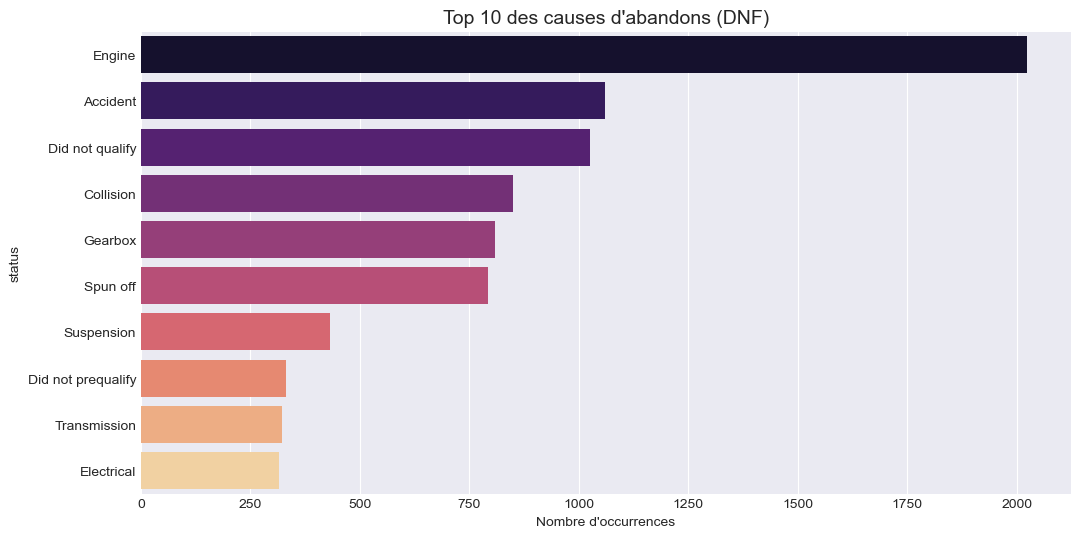

In [203]:
def analyze_reliability():
    
    # Fusion avec la table status (Assure-toi que results_df et status_df sont bien chargés avant)
    df_status = results_df.merge(status_df, on='statusId')
    
    # Filtrer ce qui n'est pas "Finished" ou "+1 Lap" (les abandons réels)
    dnf_data = df_status[~df_status['status'].str.contains('Finished|\+', regex=True)]
    
    top_causes = dnf_data['status'].value_counts().head(10)
    
    plt.figure(figsize=(12, 6))
    
    sns.barplot(
        y=top_causes.index, 
        x=top_causes.values, 
        hue=top_causes.index,  # On lie la couleur à la catégorie (Y)
        legend=False,          
        orient='h', 
        palette='magma'
    )
    
    plt.title("Top 10 des causes d'abandons (DNF)", fontsize=14)
    plt.xlabel("Nombre d'occurrences")
    plt.show()

analyze_reliability()

L'histogramme révèle une hiérarchie claire des défaillances en F1 : les problèmes mécaniques (Moteur en tête avec plus de 2000 cas) restent historiquement la cause majeure d'abandon, doublant presque la seconde cause.

Cependant, la violence de la course est omniprésente, le cumul des incidents de pilotage (Accident, Collision, Spun off) représentant un volume d'abandons supérieur à celui des moteurs seuls, soulignant que la fiabilité technique ne suffit pas pour finir une course.

Ainsi, il pourrait être intéressant de créer une feature constructor_reliability : afin d'analyser le taux de courses terminées par l'écurie sur la saison en cours.

### Datasets inutilisables pour notre modèle de prédiction

Enfin, avant de passer au merged, nous avons encore besoin de nettoyer quelques jeux de données qui sont complètement inutilisables pour notre étude. C'est le cas de seasons.csv qui est un fichier purement redondant puisqu'il n'indique que l'année est déjà donnée dans races.csv. Le dataset sprint_results.csv est également inutilisable car l'épreuve des sprints n'existe que depuis 2021. Il y a donc un fort risque de déstabilisation de notre modèle pour rien. L'impact réel des sprints (points et grille) est de toute façon déjà capturé dans nos fichiers principaux (results et qualifying). 

Ainsi, la suppression de ces 2 fichiers élimine du bruit massif sans perdre une seule information prédictive.

In [204]:
try:
    del seasons
    del sprint_results
    print("Succès : Les fichiers 'seasons' et 'sprint_results' ont été supprimés.")
except NameError:
    print("Info : Ces fichiers étaient déjà supprimés ou non chargés.")

Succès : Les fichiers 'seasons' et 'sprint_results' ont été supprimés.


### Nouvel audit de qualité de nos données

In [205]:
audit_data_quality({
    'circuits': circuits,
    'constructor_results': constructor_results,
    'constructor_standings': constructor_standings,
    'constructors': constructors,
    'driver_standings': driver_standings,
    'drivers': drivers,
    'lap_times': lap_times,
    'pit_stops': pit_stops,
    'qualifying': qualifying,
    'races': races,
    'results': results,
    'status': status
})

--- Rapport de Qualité des Données ---

Jeu de données : CIRCUITS
Dimensions : (77, 4)
Aucune valeur manquante détectée.

Jeu de données : CONSTRUCTOR_RESULTS
Dimensions : (12495, 4)
Aucune valeur manquante détectée.

Jeu de données : CONSTRUCTOR_STANDINGS
Dimensions : (13261, 6)
Aucune valeur manquante détectée.

Jeu de données : CONSTRUCTORS
Dimensions : (212, 4)
Aucune valeur manquante détectée.

Jeu de données : DRIVER_STANDINGS
Dimensions : (34574, 6)
Aucune valeur manquante détectée.

Jeu de données : DRIVERS
Dimensions : (859, 5)
Aucune valeur manquante détectée.

Jeu de données : LAP_TIMES
Dimensions : (575029, 5)
Aucune valeur manquante détectée.

Jeu de données : PIT_STOPS
Dimensions : (10945, 6)
Aucune valeur manquante détectée.

Jeu de données : QUALIFYING
Dimensions : (10234, 4)
Aucune valeur manquante détectée.

Jeu de données : RACES
Dimensions : (1125, 6)
Aucune valeur manquante détectée.

Jeu de données : RESULTS
Dimensions : (26499, 7)
Aucune valeur manquante détectée

On ne détecte désormais plus aucune valeurs manquantes dans les datasets ce qui nous arrange puisque cela signifie que nous n'aurons pas besoin de recourir à des techniques d'imputation.

# Mapping de constructeurs

Avant de commencer le merged de notre dataset ainsi qu'une étude plus approfondie, il est important de passer par une étape de mapping de nos constructeurs. En effet, nous souhaitons prédire les résultats dans un contexte récent. Ainsi une écurie ayant concourru par le passé a pu être racheté par une écurie participant actuellement aux courses. Ainsi nous devons attribuer les victoires de cette ancienne écurie à la nouvelle.

Pour les écuries plus anciennes qui n'existent plus et n'auraient pas été rachetées ou fusionnées, nous avons décidé de les garder afin que les études des anciennes courses menées par notre modèle soient plus justes.

In [206]:
constructor_mapping = {
    # Mercedes (Brackley) : Tyrrell -> BAR -> Honda -> Brawn -> Mercedes
    15: 131, 16: 131, 17: 131, 23: 131,
    # Red Bull (Milton Keynes) : Stewart -> Jaguar -> Red Bull
    19: 9, 18: 9,
    # Alpine (Enstone) : Benetton -> Renault -> Lotus -> Alpine
    22: 214, 4: 214, 208: 214,
    # Aston Martin (Silverstone) : Jordan -> Midland -> Spyker -> Force India -> Racing Point -> Aston
    20: 117, 21: 117, 24: 117, 10: 117, 211: 117,
    # RB (Faenza) : Minardi -> Toro Rosso -> AlphaTauri -> RB
    14: 213, 5: 213,
    # Sauber (Hinwil) : Sauber -> BMW Sauber -> Sauber -> Alfa Romeo -> Sauber
    51: 15 # Alfa Romeo -> Sauber (Validé)
}

print("Application du mapping constructeurs...")
results['constructorId'] = results['constructorId'].replace(constructor_mapping)
qualifying['constructorId'] = qualifying['constructorId'].replace(constructor_mapping)


Application du mapping constructeurs...


In [207]:
# Définition du Mapping (Pour identifier qui supprimer)
def get_id(name):
    res = constructors[constructors['name'] == name]['constructorId'].values
    return res[0] if len(res) > 0 else None

# Cibles (Les survivants)
merc_id = get_id('Mercedes')
rb_id = get_id('Red Bull')
alpine_id = get_id('Alpine F1 Team')
aston_id = get_id('Aston Martin')
sauber_id = get_id('Sauber')
rb_visa_id = get_id('RB F1 Team')

# Dictionnaire des ancêtres (Ceux qui doivent disparaître)
mapping = {}
# Lignée Mercedes
mapping.update({get_id('Tyrrell'): merc_id, get_id('BAR'): merc_id, get_id('Honda'): merc_id, get_id('Brawn'): merc_id})
# Lignée Red Bull
mapping.update({get_id('Stewart'): rb_id, get_id('Jaguar'): rb_id})
# Lignée Alpine
mapping.update({get_id('Benetton'): alpine_id, get_id('Renault'): alpine_id, get_id('Lotus F1'): alpine_id})
# Lignée Aston Martin
mapping.update({get_id('Jordan'): aston_id, get_id('Midland'): aston_id, get_id('Spyker'): aston_id, get_id('Force India'): aston_id, get_id('Racing Point'): aston_id})
# Lignée Sauber
mapping.update({get_id('Alfa Romeo'): sauber_id, get_id('BMW Sauber'): sauber_id})
# Lignée RB (Minardi)
mapping.update({get_id('Minardi'): rb_visa_id, get_id('Toro Rosso'): rb_visa_id, get_id('AlphaTauri'): rb_visa_id})

# Nettoyage des None
ids_to_drop = [k for k in mapping.keys() if k is not None]

# Création du Nouveau Dataset Constructeur (Suppression des ancêtres)
constructors_clean = constructors[~constructors['constructorId'].isin(ids_to_drop)].copy()

print(f"Dataset 'constructors' réduit de {len(constructors)} à {len(constructors_clean)} lignes.")
print(f"Écuries supprimées : {len(ids_to_drop)}")
print(constructors_clean.head())

Dataset 'constructors' réduit de 212 à 194 lignes.
Écuries supprimées : 18
   constructorId constructorRef         name nationality
0              1        mclaren      McLaren     British
2              3       williams     Williams     British
5              6        ferrari      Ferrari     Italian
6              7         toyota       Toyota    Japanese
7              8    super_aguri  Super Aguri    Japanese
